# Getting started with prenspire

In [1]:
import random
from pathlib import Path

import lmfit
import matplotlib.pyplot as plt
import numpy as np
from clophfit import prenspire
from clophfit.binding.fitting import (
    Dataset,
    analyze_spectra,
    analyze_spectra_glob,
    fit_binding_glob,
)
from clophfit.binding.plotting import plot_emcee

%load_ext autoreload
%autoreload 2
tpath = Path("../../tests/EnSpire")

In [2]:
ef1 = prenspire.EnspireFile(tpath / "h148g-spettroC.csv")
ef2 = prenspire.EnspireFile(tpath / "e2-T-without_sample_column.csv")
ef3 = prenspire.EnspireFile(tpath / "24well_clop0_95.csv")

In [3]:
ef3.wells, ef3._wells_platemap, ef3._platemap

(['A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'C01', 'C02', 'C03'],
 ['A03', 'A04', 'A05', 'A06', 'B01', 'B02', 'C01', 'C02', 'C03'],
 [['A', '  ', '  ', '- ', '- ', '- ', '- '],
  ['B', '- ', '- ', '  ', '  ', '  ', '  '],
  ['C', '- ', '- ', '- ', '  ', '  ', '  '],
  ['D', '  ', '  ', '  ', '  ', '  ', '  ']])

In [4]:
ef1.__dict__.keys()

dict_keys(['file', 'verbose', 'metadata', 'measurements', 'wells', '_ini', '_fin', '_wells_platemap', '_platemap'])

In [5]:
ef1.measurements.keys(), ef2.measurements.keys()

(dict_keys(['A']), dict_keys(['B', 'A', 'C', 'D', 'E', 'F', 'G', 'H']))

when testing each spectra for the presence of a single wavelength in the appropriate monochromator

In [6]:
ef2.measurements["A"]["metadata"]

{'temp': '25',
 'Monochromator': 'Excitation',
 'Min wavelength': '400',
 'Max wavelength': '510',
 'Wavelength': '530',
 'Using of excitation filter': 'Top',
 'Measurement height': '8.9',
 'Number of flashes': '50',
 'Number of flashes integrated': '50',
 'Flash power': '100'}

In [7]:
ef2.measurements["A"].keys()

dict_keys(['metadata', 'lambda', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07'])

In [8]:
random.seed(11)
random.sample(ef1.measurements["A"]["F01"], 7)

[2163.0, 607.0, 1846.0, 517.0, 572.0, 2145.0, 2028.0]

In [9]:
fp = tpath / "h148g-spettroC-nota.csv"
n1 = prenspire.Note(fp, verbose=1)
n1._note.set_index("Well").loc["A01", ["Name", "Temp"]]

Wells ['A01', 'A02']...['G04', 'G05'] generated.


Name    H148G
Temp     20.0
Name: A01, dtype: object

In [10]:
n1.__dict__.keys()

dict_keys(['fpath', 'verbose', 'wells', '_note', 'titrations'])

In [11]:
n1.wells == ef1.wells, n1.wells == ef2.wells

(True, False)

In [12]:
n1.build_titrations(ef1)
tit0 = n1.titrations["H148G"][20.0]["Cl_0.0"]["A"]
tit3 = n1.titrations["H148G"][20.0]["pH_7.4"]["A"]
tit0

,5.2,6.3,7.4,8.1,8.2
272.0,3151.0,4181.0,16413.0,29192.0,28816.0
273.0,3130.0,4204.0,16926.0,29909.0,29545.0
274.0,3043.0,4232.0,17331.0,30900.0,30750.0
275.0,3079.0,4283.0,17680.0,31717.0,31547.0
276.0,2975.0,4264.0,18020.0,32564.0,32336.0
...,...,...,...,...,...
496.0,636.0,4689.0,43230.0,87203.0,87842.0
497.0,683.0,4923.0,45173.0,89719.0,90666.0
498.0,632.0,4900.0,46725.0,93452.0,94101.0
499.0,854.0,5140.0,48452.0,96643.0,97506.0


<Axes: >

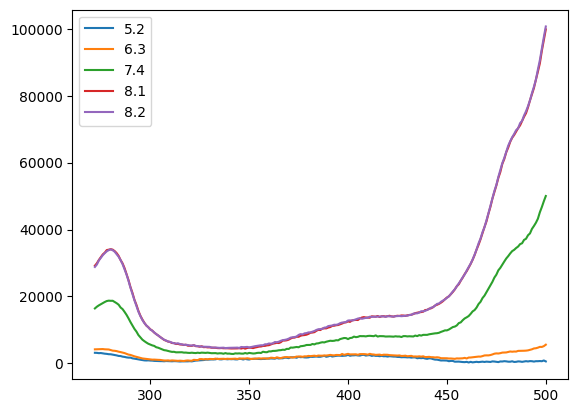

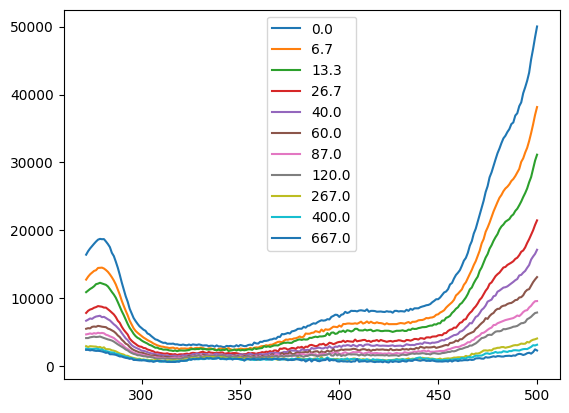

In [13]:
tit0.plot()
tit3.plot()

In [14]:
ef = prenspire.EnspireFile(tpath / "G10.csv")
fp = tpath / "NTT-G10_note.csv"
nn = prenspire.Note(fp, verbose=1)
nn.build_titrations(ef)
spectra = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["C"]

Wells ['D01', 'D02']...['G07', 'G08'] generated.


24.000000000000046


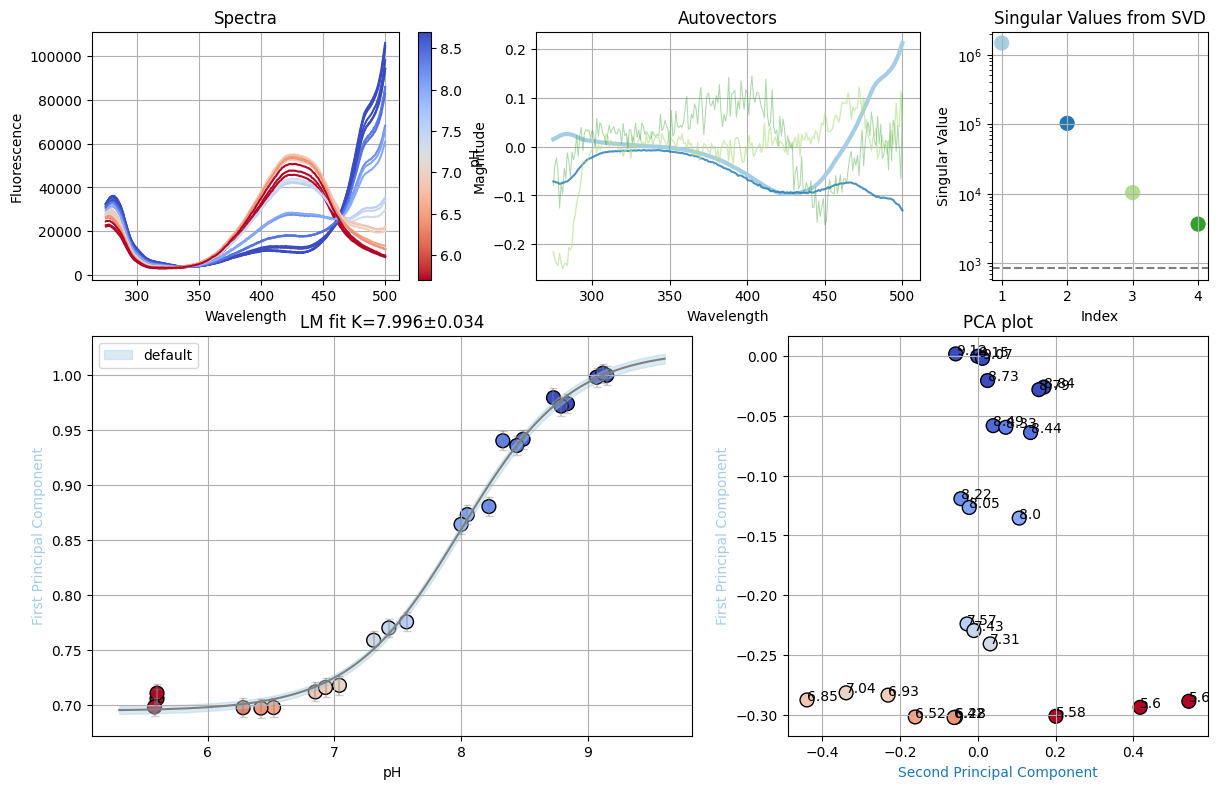

In [15]:
f_res = analyze_spectra(spectra, is_ph=True, band=None)
print(f_res.result.chisqr)
plt.show()
f_res.figure

In [16]:
def dataset_from_lres(lkey, lres, is_ph):
    x, y = {}, {}
    for k, res in zip(lkey, lres):
        x[k] = res.mini.userargs[0]["default"].x
        y[k] = res.mini.userargs[0]["default"].y
    return Dataset(x, y, is_ph)


spectra_A = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["A"]
spectra_C = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["C"]
spectra_D = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]["D"]

resA = analyze_spectra(spectra_A, "pH", (466, 510))
resC = analyze_spectra(spectra_C, "pH", (470, 500))
resD = analyze_spectra(spectra_D, "pH", (450, 600))
ds_bands = dataset_from_lres(["A", "C", "D"], [resA, resC, resD], True)

resA = analyze_spectra(spectra_A, "pH")
resC = analyze_spectra(spectra_C, "pH")
resD = analyze_spectra(spectra_D, "pH")
ds_svd = dataset_from_lres(["A", "C", "D"], [resA, resC, resD], True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:18<00:00, 97.86it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 36;
tau: [54.0759028  47.01313848 54.99540025 44.43316404 40.93936786]


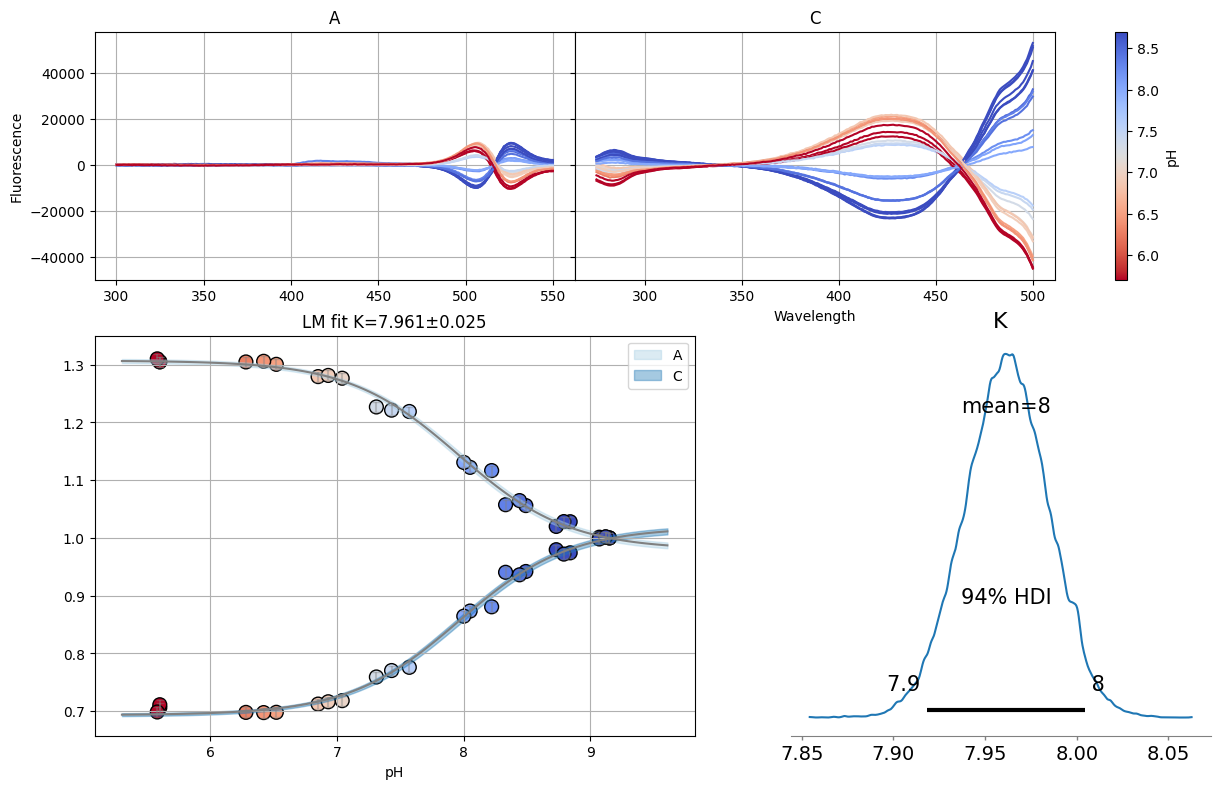

In [17]:
dbands = {"D": (466, 510)}
tit = nn.titrations["NTT-G10"][20.0]["Cl_0.0"]
sgres = analyze_spectra_glob(tit, ds_svd, dbands)
sgres.svd.figure
sgres.gsvd.figure

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:21<00:00, 85.41it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 36;
tau: [79.28631938 53.77383936 76.65253672 60.96310711 73.37573696 56.61336481
 63.09191874]


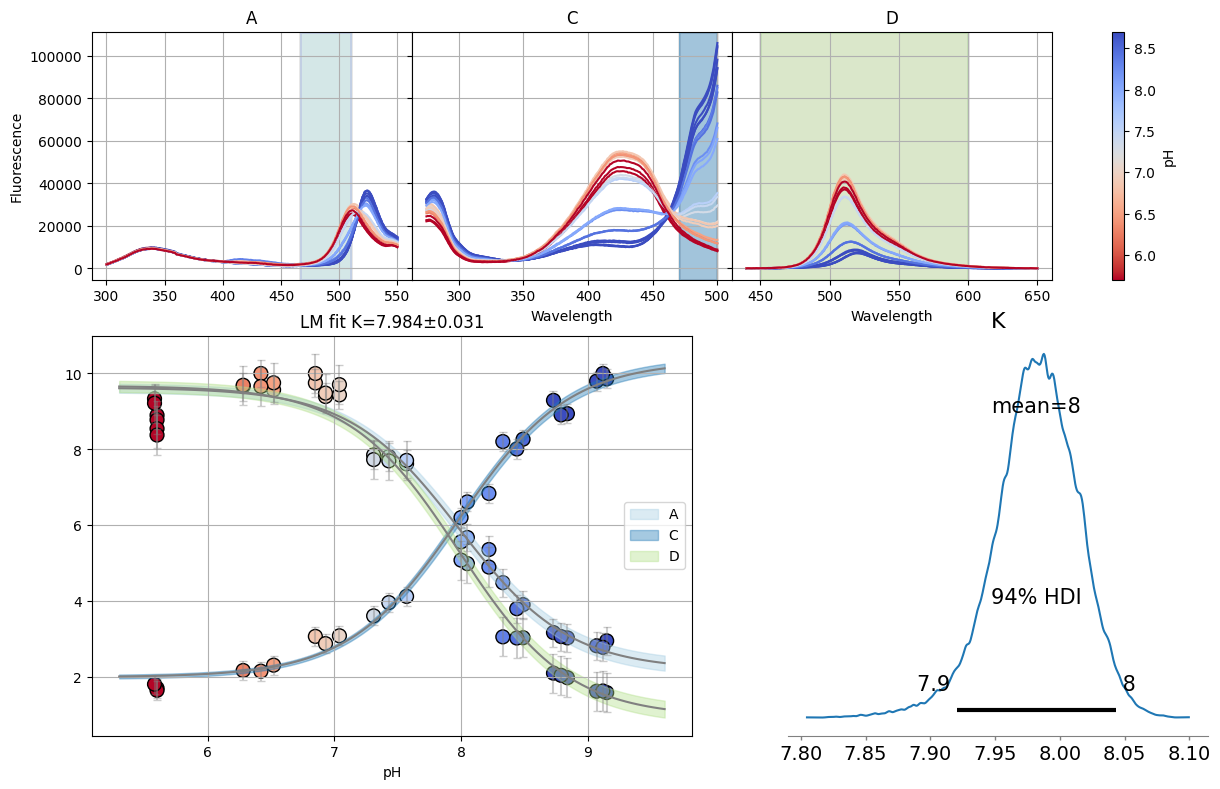

In [18]:
dbands = {"A": (466, 510), "C": (470, 500), "D": (450, 600)}
sgres = analyze_spectra_glob(nn.titrations["NTT-G10"][20.0]["Cl_0.0"], ds_bands, dbands)
sgres.bands.figure

In [19]:
ci = lmfit.conf_interval(sgres.bands.mini, sgres.bands.result)
print(lmfit.ci_report(ci, ndigits=2, with_offset=False))

      99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 S0_A:   1.65   1.84   2.02   2.20   2.37   2.54   2.72
 S1_A:   9.23   9.37   9.50   9.63   9.76   9.89  10.03
 S0_C:   9.90  10.05  10.19  10.33  10.47  10.62  10.79
 S1_C:   1.70   1.81   1.91   2.00   2.10   2.19   2.29
 S0_D:   0.21   0.47   0.72   0.96   1.19   1.42   1.67
 S1_D:   9.12   9.31   9.50   9.68   9.85  10.04  10.23
 K   :   7.89   7.92   7.95   7.98   8.02   8.05   8.08


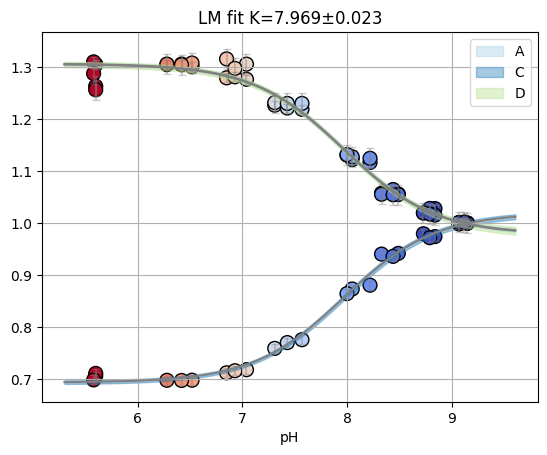

In [20]:
res = fit_binding_glob(ds_svd, True)
res.figure

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:15<00:00, 118.87it/s]


(<Figure size 550x550 with 4 Axes>, [])

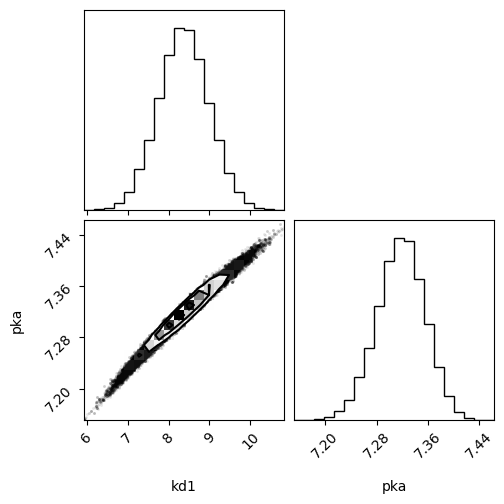

In [21]:
xx = np.array([5.2, 6.3, 7.4, 8.1, 8.2])
yy = np.array([6.05, 12.2, 20.38, 48.2, 80.3])


def kd(x, kd1, pka):
    return kd1 * (1 + 10 ** (pka - x)) / 10 ** (pka - x)


model = lmfit.Model(kd)
params = lmfit.Parameters()
params.add("kd1", value=10.0)
params.add("pka", value=6.6)
result = model.fit(yy, params, x=xx)
result_emcee = result.emcee(steps=1800, burn=150)

fig = plot_emcee(result_emcee.flatchain)